In [1]:
%matplotlib inline
#use python 3.11.3
from osgeo import gdal, osr # install gdal before geopandas to avoid running into package conflict
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
# load AGB data and extract its coordinates
agb_data = gpd.read_file(r"D:\s4g\agb\assignment\Kenya_AGB.geojson")
print(agb_data.head())

agb_points = agb_data.geometry

          index  agbd_ton_ha                  geometry
0  subplot_9530    12.927273  POINT (35.28417 0.06594)
1  subplot_8117     3.071157  POINT (35.26615 0.04683)
2  subplot_8594    19.815331  POINT (35.28181 0.01081)
3  subplot_8495     1.984620  POINT (35.27403 0.05106)
4  subplot_8505    15.851218  POINT (35.29551 0.04019)


In [30]:
# load landsat NDVI data
landsat_ndvi = gdal.Open(r"D:\s4g\agb\assignment\agbassignment\NDVI_mean_2023.tif")
landsat_ndvi_band = landsat_ndvi.GetRasterBand(1) # specify the band with information
landsat_ndvi_array = landsat_ndvi_band.ReadAsArray() #read the data into numerical array

In [31]:
# create an empty array to store predicted AGB values
agb_predicted_array = np.empty(landsat_ndvi_array.shape) # returns the shape of array

In [34]:
# extracting NDVI values at AGB coordinate points

#creta an empty df to store the NDVI values that will be extracted
ndvi_at_agb_points = []

#extract the image pixels at corespodning agb point coordinates
for point in agb_points:
    x, y = point.xy
    col = int((x[0] - landsat_ndvi.GetGeoTransform()[0]) / landsat_ndvi.GetGeoTransform()[1])
    row = int((y[0] - landsat_ndvi.GetGeoTransform()[3]) / landsat_ndvi.GetGeoTransform()[5])
    
    #extract only pixels that overlay with the points
    if 0 <= row < landsat_ndvi_array.shape[0] and 0 <= col < landsat_ndvi_array.shape[1]:
        ndvi_value = landsat_ndvi_array[row, col]
        ndvi_at_agb_points.append(ndvi_value)
    else: 
        ndvi_at_agb_points.append(np.nan)

In [35]:
# combine the ndvi and agb dataset into one df for easy analysis

data = pd.DataFrame({"AGB (ha)": agb_data["agbd_ton_ha"], "Landsat NDVI": ndvi_at_agb_points})
print(data.head())

    AGB (ha)  Landsat NDVI
0  12.927273      0.563370
1   3.071157      0.531227
2  19.815331      0.611070
3   1.984620      0.657350
4  15.851218      0.533956


In [37]:
# modelling

#identify the x and y data
X = data[["Landsat NDVI"]] #somehow using single brackets [] will thro an ValueError: Expected 2D array, got 1D array instead
y = data["AGB (ha)"]       # https://stackoverflow.com/questions/45554008/error-in-python-script-expected-2d-array-got-1d-array-instead

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45) #may includ for reproducibility

# fit the random foret regressipon model
rf_model = RandomForestRegressor(n_estimators=100, random_state=45)
rf_model.fit(X_train.values, y_train.values) #explicitly include .value to avoid user warning

RandomForestRegressor(random_state=45)

In [46]:
# predicting agb 

#create an empty aray to store predicted agb values
predicted_agb_array = np.empty(landsat_ndvi_array.shape)

for i in range(landsat_ndvi_array.shape[0]):
    for j in range(landsat_ndvi_array.shape[1]):
        ndvi_value = landsat_ndvi_array[i, j]
        agb_prediction = rf_model.predict([[ndvi_value]])
        predicted_agb_array[i, j] = agb_prediction
        
# creta the path the store the output image including the file name
output_path = r"D:\s4g\agb\assignment\agbassignment\predicted_agb_map.tif"

#create a new geotif file with customed path and name, and copy shape of landsat
output_raster = gdal.GetDriverByName("GTiff").Create(output_path, 
                                                  landsat_ndvi_array.shape[1],
                                                  landsat_ndvi_array.shape[0], 1,
                                                  gdal.GDT_Float32)
output_raster.SetGeoTransform(landsat_ndvi.GetGeoTransform())

#define the metadata of the ouput image (predicted agb image, copy from landsat img

srs = osr.SpatialReference()
srs.ImportFromWkt(landsat_ndvi.GetProjectionRef())
output_raster.SetProjection(srs.ExportToWkt())

#write the predited agb values to the output raster
output_raster.GetRasterBand(1).WriteArray(predicted_agb_array)

#close raster
ouput_raster = None 

RMSE: 8.605632569615626


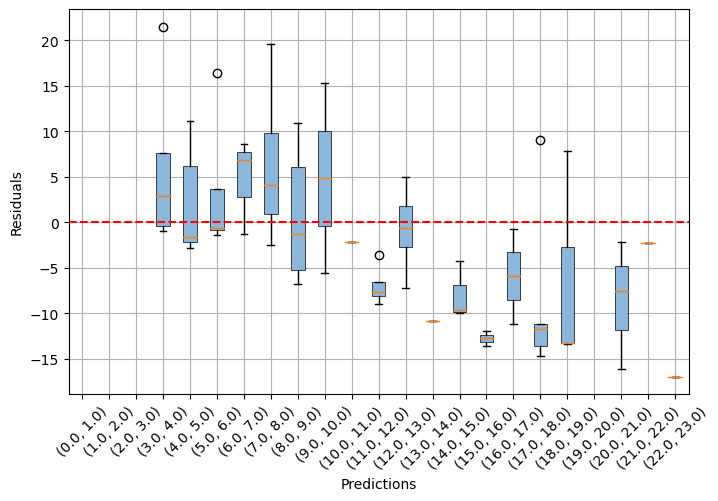

In [58]:
# residual analysis to for error estinmations in predictions
y_pred = rf_model.predict(X_test.values) #always include .value to avoid user warnin error
residuals = y_test - y_pred

#define bin intervals 
bin_width = 1

#calculate the bin edges upto the max value
bin_edges = np.arange(0, np.max(y_pred) + bin_width, bin_width)

#cretae a new varaible to store the lables for ecah bin
bin_labels = [(edge, edge + bin_width) for edge in bin_edges[:-1]]

#categorise dara into bins based on y_pred

binned_residuals = []
for i in range(len(bin_edges) -1):
    lower_edge, upper_edge = bin_edges[i], bin_edges[i + 1]
    mask = (y_pred >= lower_edge) & (y_pred < upper_edge)
    binned_residuals.append(residuals[mask])
    
# plot the figure
plt.figure(figsize=(8, 5))

#give boxplot some nice colors
boxprops = dict(linewidth=0.5, color='black', facecolor='#8cb6da') 
boxplot = plt.boxplot(binned_residuals, labels=bin_labels, patch_artist=True, boxprops=boxprops)

# label the figure
plt.xlabel("Predictions")
plt.ylabel("Residuals")

#add aline at y=0 to define negative and positive residuals
plt.axhline(0, color="red", linestyle="--")

#add tick marks and rotate the x albels for better reading
plt.grid("True")
plt.xticks(rotation=45)

#calcukate the overall error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Tadaa!!, low RMSE,, but high marginal errors in predictions